# Q-learning

In [1]:
import pandas as pd
import numpy as np
import random
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tqdm import tqdm
from time import time

In [2]:
seeds = [
    960703545, 1277478588, 1936856304, 186872697, 1859168769, 1598189534, 1822174485, 1871883252, 694388766,
    188312339, 773370613, 2125204119, 2041095833, 1384311643, 1000004583, 358485174, 1695858027, 762772169,
    437720306, 939612284
]

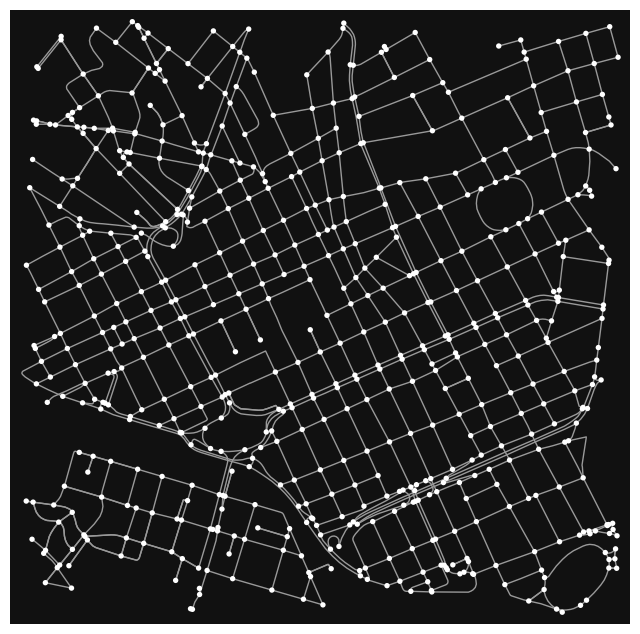

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [3]:
G = ox.graph_from_address('Campinas, São Paulo', network_type='drive')
G = nx.convert_node_labels_to_integers(G)
ox.plot_graph(G)

In [4]:
class Environment:
  """
  Simulation of graph route that can be deterministic and stochastic.
  The main functionalities is to reset the simulation and returns the state based in the action.
  """

  def __init__(self, G, source, target, reward="weighted", mode="deterministic"):
    self.G = G
    self.max_weight = max([G[u][v][0]["length"] for u, v, m in G.edges if m == 0])
    self.source = source
    self.target = target
    self.reward = reward

    assert mode in ["deterministic", "stochastic"], "Mode must be deterministic or stochastic"
    if mode == "deterministic":
        self.step = self.step_deterministic
    elif mode == "stochastic":
        self.step = self.step_stochastic

  def get_n_states(self):
    """Get number of states"""
    return len(self.G.nodes)

  def reset(self):
    """Return to the source state that is not the destination"""
    self.state = self.source
    # self.state = np.random.choice(list(self.G.nodes))
    # while self.state == self.target:
        # self.state = np.random.choice(list(self.G.nodes))
    return self.state

  def step_deterministic(self, action):
    """Return new state, reward, and if simulation is done"""

    # if is not the target, and the action is to stay in the same node
    if (action == self.state) & (action != self.target):
      return self.state, -1, False
    
    # if reached the target
    if self.state == self.target:
      return self.state, 10000, True
    
    # weight of the edge
    w = self.G[self.state][action][0]["length"] / self.max_weight
    # now, the state is the next node
    self.state = action

    # if the action leaves to a dead end
    neighbors = list(self.G.neighbors(self.state))
    if len(neighbors) == 0:
      return self.state, -1000, True

    if self.reward == "unit":
        return self.state, 0, False
    elif self.reward == "weighted":
        return self.state, -w, False
    
  def step_stochastic(self, action):
      """Return new state, reward, and if the destination is reached"""
      if np.random.rand() < 0.05:  # 5% probability of not moving
          return self.state, 0, False
      
      # if is not the target, and the action is to stay in the same node
      if (action == self.state) & (action != self.target):
        return self.state, -1, False
      
      # if reached the target
      if self.state == self.target:
        return self.state, 10000, True
      
      # weight of the edge
      w = self.G[self.state][action][0]["length"] / self.max_weight
      self.state = action

      # if the action leaves to a dead end
      neighbors = list(self.G.neighbors(self.state))
      if len(neighbors) == 0:
        return self.state, -1000, True

      if self.reward == "unit":
        return self.state, 0, False
      elif self.reward == "weighted":
        w_ = w + np.random.normal(scale=0.1)
        return self.state, -w_, False

In [5]:
class QLAgent:
    def __init__(
        self, 
        env, 
        learning_rate = 0.7, 
        gamma = 0.99,
        min_epsilon = 0.05,
        max_epsilon = 1,
        n_episodes = 1000,
        max_steps = 1000,
        tol = 1e-6,
        seed = None
    ):
        self.env = env
        self.n_states = env.get_n_states()
        self.set_Q()
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.min_epsilon = min_epsilon
        self.max_epsilon = max_epsilon
        self.n_episodes = n_episodes
        self.max_steps = max_steps
        self.tol = tol
        self.seed = seed
        if seed is not None:
            self.set_seed(seed)

    def set_Q(self):
        self.Q = np.zeros((self.n_states, self.n_states))
        for state in range(self.n_states):
            for action in range(self.n_states):
                if state == action:
                    self.Q[state, action] = 0
                else:
                    try:
                        self.env.G[state][action][0]["length"]
                        self.Q[state, action] = 0
                    except:
                        self.Q[state, action] = -np.inf
                
    def set_seed(self, seed):
        random.seed(seed)
        np.random.seed(seed)
    
    def greedy_policy(self, state):
        """Greedy policy that returns the action with the highest Q value"""
        return np.random.choice(np.where(self.Q[state, :] == np.max(self.Q[state, :]))[0])
    
    def epsilon_greedy_policy(self, state, epsilon):
        """Epsilon greedy policy that returns a random action with probability epsilon"""
        if np.random.uniform(0, 1) < epsilon:
            neighbors = list(self.env.G.neighbors(state))
            return np.random.choice(neighbors)
        else:
            return self.greedy_policy(state)

    def generate_episode(self, epsilon):
        state = self.env.reset()
        self.episode_rewards.append(0)
        route = [state]

        for step in range(self.max_steps):
            # Choose action and get reward
            action = self.epsilon_greedy_policy(state, epsilon)
            new_state, reward, done = self.env.step(action)
            self.episode_rewards[-1] += reward    
            
            # update Q table based on Bellman equation
            self.Q[state, action] += self.learning_rate * (
                reward
                + self.gamma * np.max(self.Q[new_state, :])
                - self.Q[state, action]
            )
            state = new_state
            route.append(state)

            if done:
                break
    
    def update_epsilon(self):
        self.epsilon -= (self.max_epsilon - self.min_epsilon) / self.n_episodes
    
    def train(self):
        self.epsilon = self.max_epsilon
        self.episode_rewards = []
        for episode in range(self.n_episodes):
            self.generate_episode(self.epsilon)
            self.update_epsilon()
            
        self.policy = {i : self.greedy_policy(i) for i in range(self.n_states)}
          

    def route_to_target(self, G, source, target):
        route = [source]
        state = source
        cost = 0
        k = 0
        while state != target and k < 1000:
            new_state = self.policy[state]
            if new_state == state:
                cost = np.inf
                route.append(new_state)
                break
            cost += G[state][new_state][0]["length"]
            state = new_state
            route.append(state)
            k += 1
        return route, cost

In [13]:
def plot_all_paths_policy(G, policy, source, target):
    """_summary_

    :param G: network
    :type G: networkx.Graph
    :param policy: dict with nodes in keys and the action in values
    :type policy: dict
    :param source: source node
    :type source: int
    :param target: target node
    :type target: int
    """

    plt.scatter(
        [G.nodes[i]["x"] for i in G.nodes],
        [G.nodes[i]["y"] for i in G.nodes],
        alpha = 0.25
    )

    for i in G.nodes:
        dest = policy[i]
        
        # verify if there is a edge between i and dest, if not, continue
        if (i, dest) not in G.edges:
            continue
        
        plt.arrow(
            G.nodes[i]["x"], 
            G.nodes[i]["y"], 
            (G.nodes[dest]["x"] - G.nodes[i]["x"]) * 0.7, 
            (G.nodes[dest]["y"] - G.nodes[i]["y"]) * 0.7, 
            alpha = 0.8, 
            width = 0.0001
        )

    # plot the source and target
    plt.scatter(
        [G.nodes[source]["x"], G.nodes[target]["x"]], 
        [G.nodes[source]["y"], G.nodes[target]["y"]], 
        color = ["green", "red" ],
        alpha = 1,
        s = 100
    )

    # add legend to source and target with the color

    red_patch = mpatches.Patch(color='red', label='Target')
    green_patch = mpatches.Patch(color='green', label='Source')
    plt.legend(handles=[red_patch, green_patch])

    plt.xticks([])
    plt.yticks([])
    plt.show()

def plot_few_steps_policy(G, policy, source, target, steps=5):
    """_summary_

    :param G: network
    :type G: networkx.Graph
    :param policy: dict with nodes in keys and the action in values
    :type policy: dict
    :param source: source node
    :type source: int
    :param target: target node
    :type target: int
    :param steps: number of steps to plot, defaults to 5
    :type steps: int, optional
    """

    plt.scatter(
        [G.nodes[i]["x"] for i in G.nodes],
        [G.nodes[i]["y"] for i in G.nodes],
        alpha = 0.25
    )

    # plot the edges
    for u, v, m in G.edges:
        if m == 0:
            plt.plot(
                [G.nodes[u]["x"], G.nodes[v]["x"]], 
                [G.nodes[u]["y"], G.nodes[v]["y"]], 
                color = "black",
                alpha = 0.25
            )

    state = source
    for i in range(steps):
        dest = policy[state]
        
        # verify if there is a edge between i and dest, if not, continue
        if (state, dest) not in G.edges:
            continue
        
        plt.arrow(
            G.nodes[state]["x"], 
            G.nodes[state]["y"], 
            (G.nodes[dest]["x"] - G.nodes[state]["x"]) * 0.95, 
            (G.nodes[dest]["y"] - G.nodes[state]["y"]) * 0.95, 
            alpha = 0.8, 
            width = 0.0001
        )
        state = dest

    # plot the source and target
    plt.scatter(
        [G.nodes[source]["x"], G.nodes[target]["x"]], 
        [G.nodes[source]["y"], G.nodes[target]["y"]], 
        color = ["green", "red" ],
        alpha = 1,
        s = 100
    )

    # add legend to source and target with the color

    red_patch = mpatches.Patch(color='red', label='Target')
    green_patch = mpatches.Patch(color='green', label='Source')
    plt.legend(handles=[red_patch, green_patch])

    plt.xticks([])
    plt.yticks([])
    

In [7]:
def experiment_handler(seeds, env, fixed_agent_params, testing_agent_param):
    testing_agent_param_name = testing_agent_param[0]
    testing_agent_param_values = testing_agent_param[1]
    results = []
    env.reset()
    for value in tqdm(testing_agent_param_values):
        fixed_agent_params[testing_agent_param_name] = value
        for i, seed in enumerate(seeds):
            start = time()
            agent = QLAgent(
                env = env,
                seed = seed,
                **fixed_agent_params,
            )
            agent.train()
            end = time()
            route, cost = agent.route_to_target(G, env.source, env.target)
            results.append(
                {"seed" : seed,
                 testing_agent_param_name : value,
                 "cost" : cost,
                 "time" : end - start,
                 "rewards" : agent.episode_rewards,
                }
            )
            env.reset()

    return results

In [8]:
source = 507
target = 235
source, target

(507, 235)

In [24]:
env = Environment(G, source, target, "unit", "deterministic")
fixed_agent_params = {
    "n_episodes" : 1000,
    "max_steps" : 1000,
}
results_gamma = experiment_handler(
    seeds,
    env,
    fixed_agent_params,
    ["gamma", [0.1, 0.25, 0.5, 0.9, 0.99]]
)
pd.DataFrame(results_gamma).to_json("results/unit_deterministic_gamma.json")
results_lr = experiment_handler(
    seeds,
    env,
    fixed_agent_params,
    ["learning_rate", [0.05, 0.1, 0.3, 0.5, 0.7]]
)
pd.DataFrame(results_lr).to_json("results/unit_deterministic_lr.json")
env = Environment(G, source, target, "weighted", "deterministic")
results_gamma = experiment_handler(
    seeds,
    env,
    fixed_agent_params,
    ["gamma", [0.1, 0.25, 0.5, 0.9, 0.99]]
)
pd.DataFrame(results_gamma).to_json("results/weighted_deterministic_gamma.json")
results_lr = experiment_handler(
    seeds,
    env,
    fixed_agent_params,
    ["learning_rate", [0.05, 0.1, 0.3, 0.5, 0.7]]
)
pd.DataFrame(results_lr).to_json("results/weighted_deterministic_lr.json")

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [03:16<00:00, 39.33s/it]


In [28]:
env = Environment(G, source, target, "unit", "stochastic")
fixed_agent_params = {
    "n_episodes" : 1000,
    "max_steps" : 1000,
}
results_gamma = experiment_handler(
    seeds,
    env,
    fixed_agent_params,
    ["gamma", [0.1, 0.25, 0.5, 0.9, 0.99]]
)
pd.DataFrame(results_gamma).to_json("results/unit_stochastic_gamma.json")
results_lr = experiment_handler(
    seeds,
    env,
    fixed_agent_params,
    ["learning_rate", [0.05, 0.1, 0.3, 0.5, 0.7]]
)
pd.DataFrame(results_lr).to_json("results/unit_stochastic_lr.json")
env = Environment(G, source, target, "weighted", "stochastic")
results_gamma = experiment_handler(
    seeds,
    env,
    fixed_agent_params,
    ["gamma", [0.1, 0.25, 0.5, 0.9, 0.99]]
)
pd.DataFrame(results_gamma).to_json("results/weighted_stochastic_gamma.json")
results_lr = experiment_handler(
    seeds,
    env,
    fixed_agent_params,
    ["learning_rate", [0.05, 0.1, 0.3, 0.5, 0.7]]
)
pd.DataFrame(results_lr).to_json("results/weighted_stochastic_lr.json")

100%|██████████| 5/5 [04:03<00:00, 48.79s/it]


In [9]:

def analysis_results(reward_method, env_method):
    results_lr = pd.read_json(f"results/{reward_method}_{env_method}_lr.json")
    results_gamma = pd.read_json(f"results/{reward_method}_{env_method}_gamma.json")
    results_lr["rewards"] = results_lr.rewards.apply(np.mean)
    results_gamma["rewards"] = results_gamma.rewards.apply(np.mean)

    results_lr = results_lr.groupby("learning_rate").agg({
        "cost" : ["mean", "std"],
        "time" : ["mean", "std"],
        "rewards" : ["mean", "std"]
    })
    results_lr.columns = ["_".join(col) for col in results_lr.columns]
    results_lr = results_lr.reset_index()

    results_gamma = results_gamma.groupby("gamma").agg({
        "cost" : ["mean", "std"],
        "time" : ["mean", "std"],
        "rewards" : ["mean", "std"]
    })
    results_gamma.columns = ["_".join(col) for col in results_gamma.columns]
    results_gamma = results_gamma.reset_index()
    plot_results_experiments(results_lr, results_gamma, f"{reward_method} reward and {env_method} environment")

def plot_results_experiments(results_lr, results_gamma, title):
    """Plot the results of the experiments varying learning rate and gamma.

    Parameters
    ----------
    results_lr : pd.DataFrame
        Dataframe with columns learning_rate, cost_mean, cost_std, time_mean, time_std, rewards_mean, rewards_std
    results_gamma : pd.DataFrame
        Dataframe with columns gamma, cost_mean, cost_std, time_mean, time_std, rewards_mean, rewards_std
    title : str 
        Title of the plot
    """
    def plot_line_plot_err(df, param, cost, ax):
        ax.plot(df[param], df[f"{cost}_mean"], color = "black")
        ax.fill_between(
            df[param],
            df[f"{cost}_mean"] - df[f"{cost}_std"],
            df[f"{cost}_mean"] + df[f"{cost}_std"],
            color = "black",
            alpha = 0.2
        )
        ax.set_xlabel(param)
        ax.set_ylabel(cost)
        ax.set_title(f"{cost} by {param}")
        ax.grid()

    fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (20, 10))
    axs = axs.flatten()

    plot_line_plot_err(results_lr, "learning_rate", "cost", axs[0])
    plot_line_plot_err(results_lr, "learning_rate", "time", axs[1])
    plot_line_plot_err(results_lr, "learning_rate", "rewards", axs[2])

    plot_line_plot_err(results_gamma, "gamma", "cost", axs[3])
    plot_line_plot_err(results_gamma, "gamma", "time", axs[4])
    plot_line_plot_err(results_gamma, "gamma", "rewards", axs[5])

    plt.suptitle(title, fontsize = 16)
    plt.show()


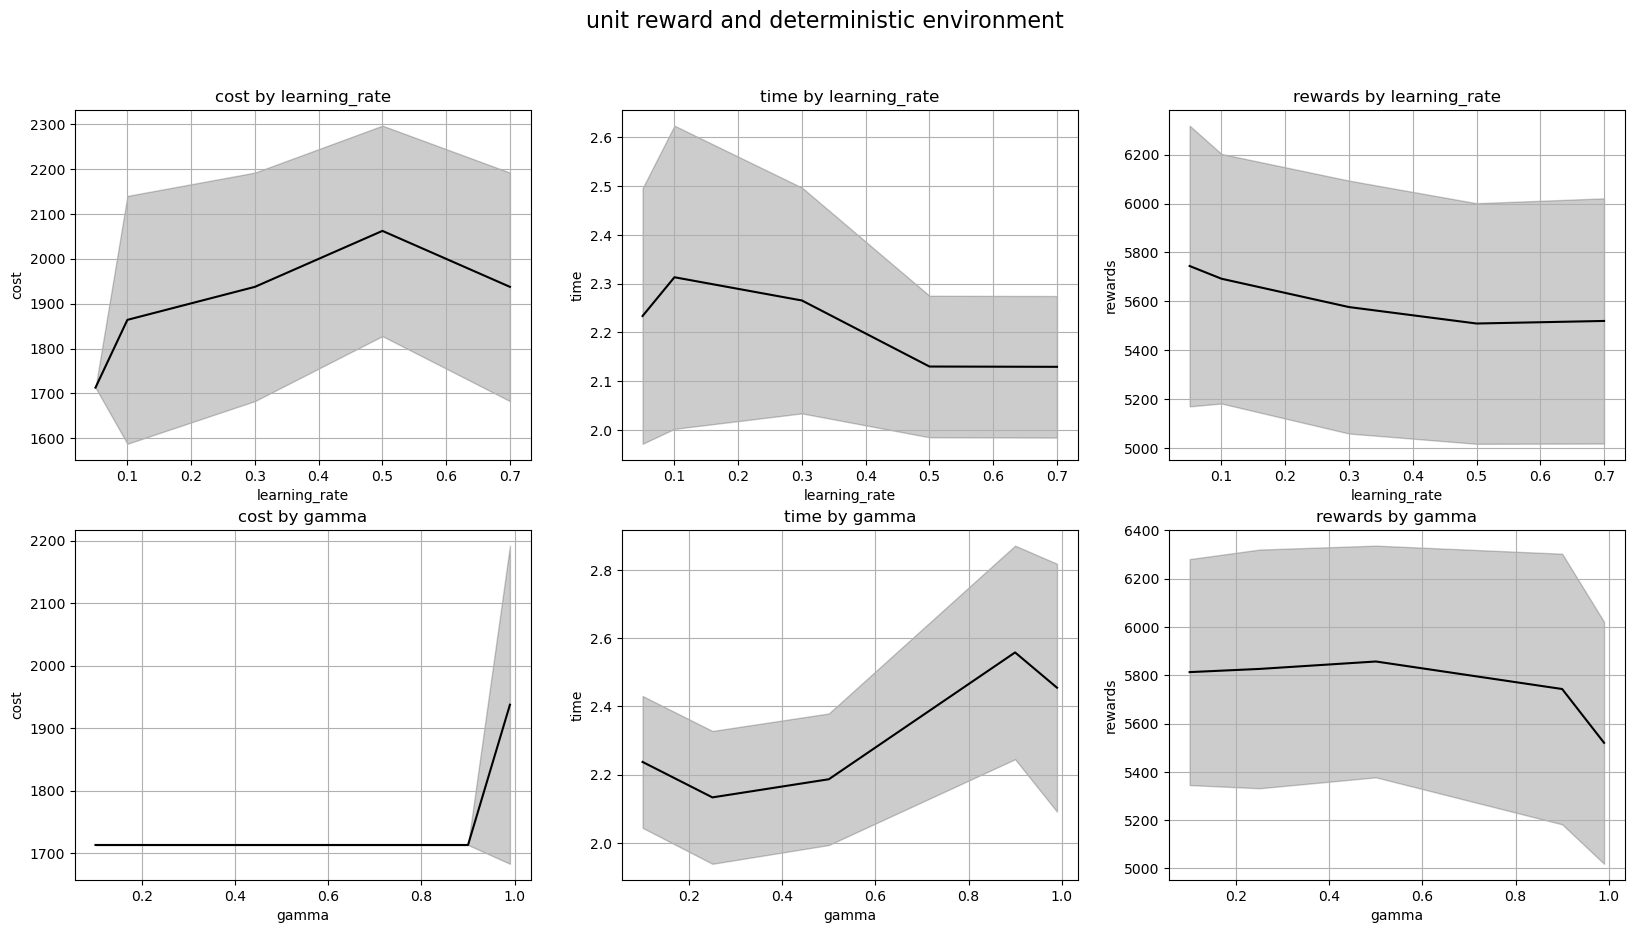

In [32]:
analysis_results("unit", "deterministic")

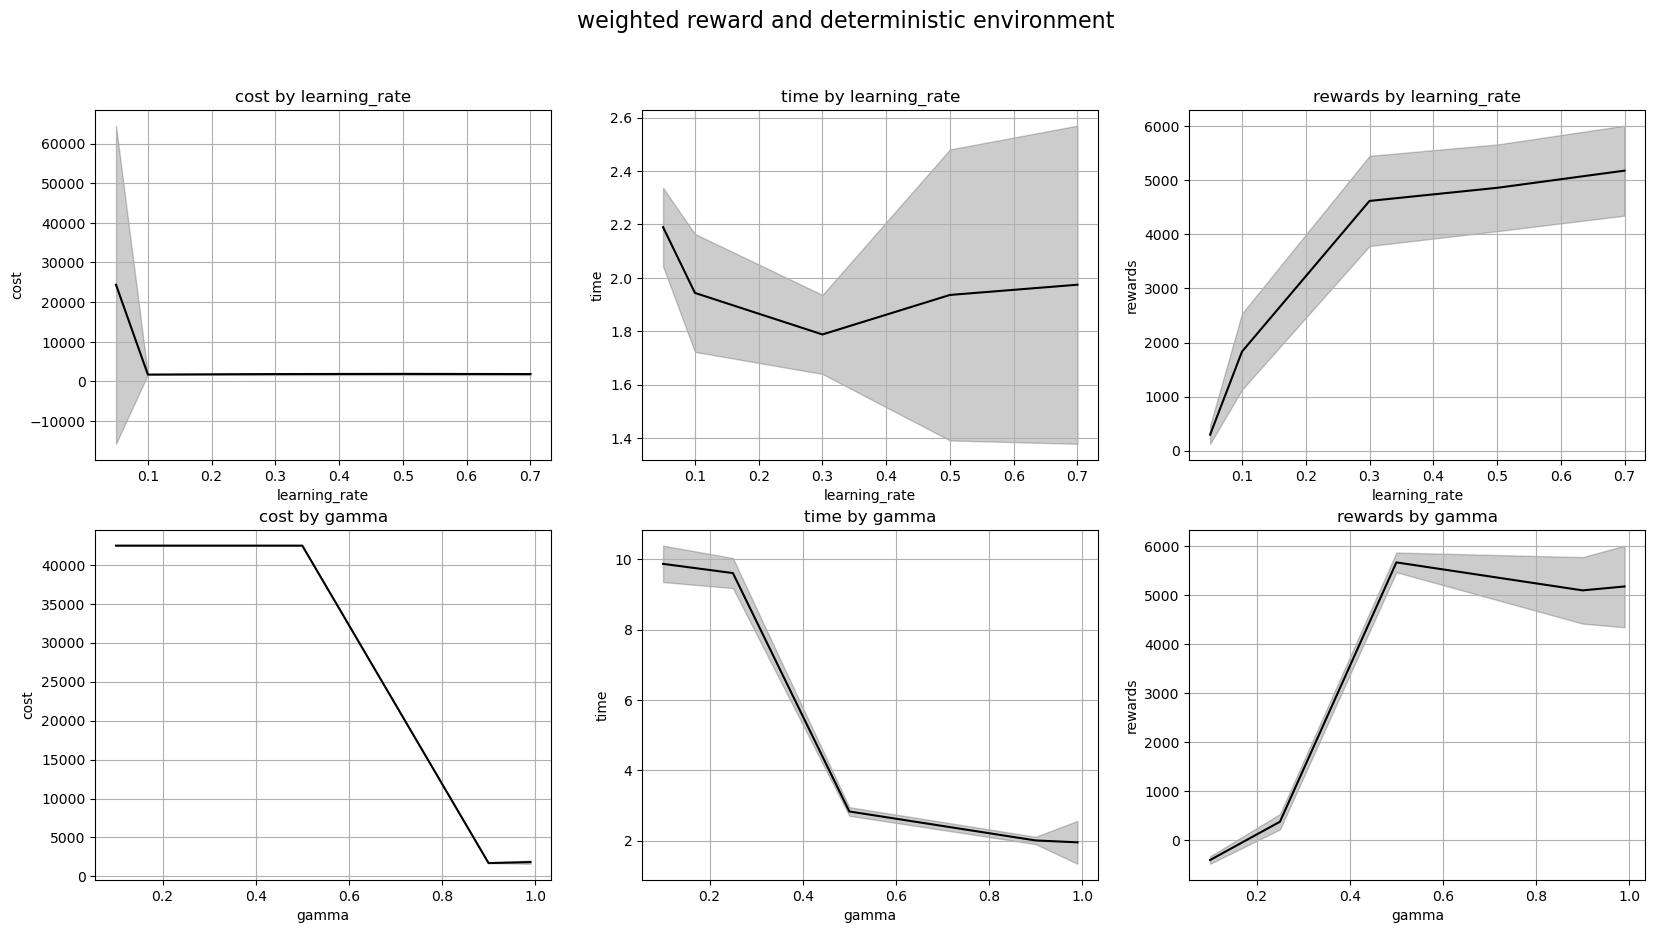

In [25]:
analysis_results("weighted", "deterministic")

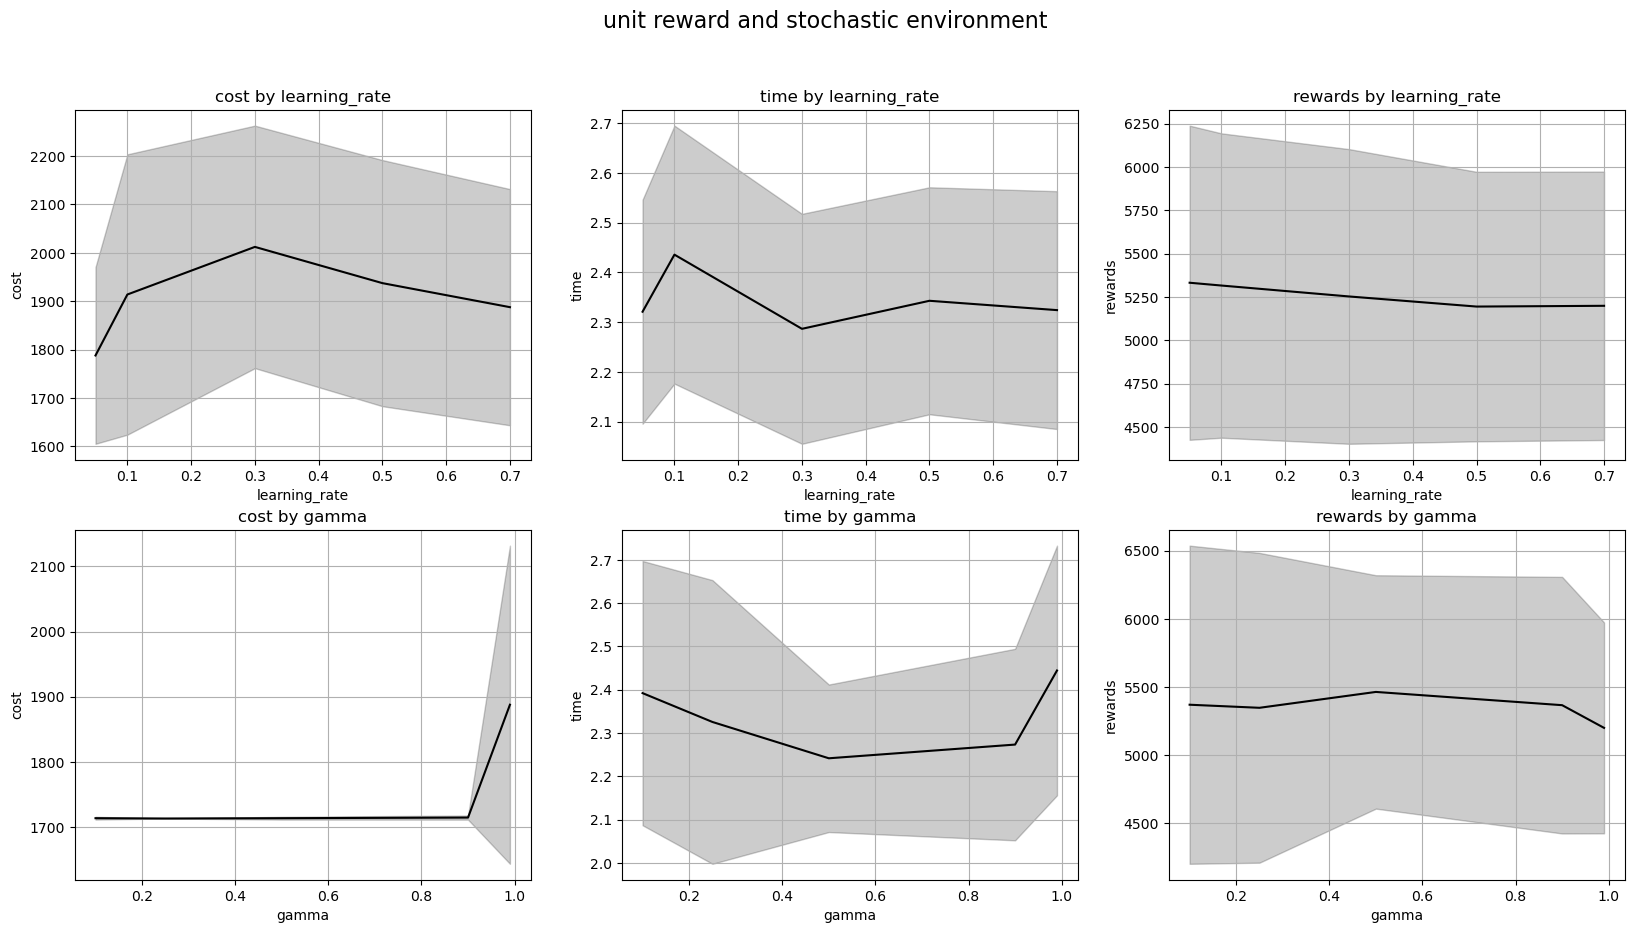

In [29]:
analysis_results("unit", "stochastic")

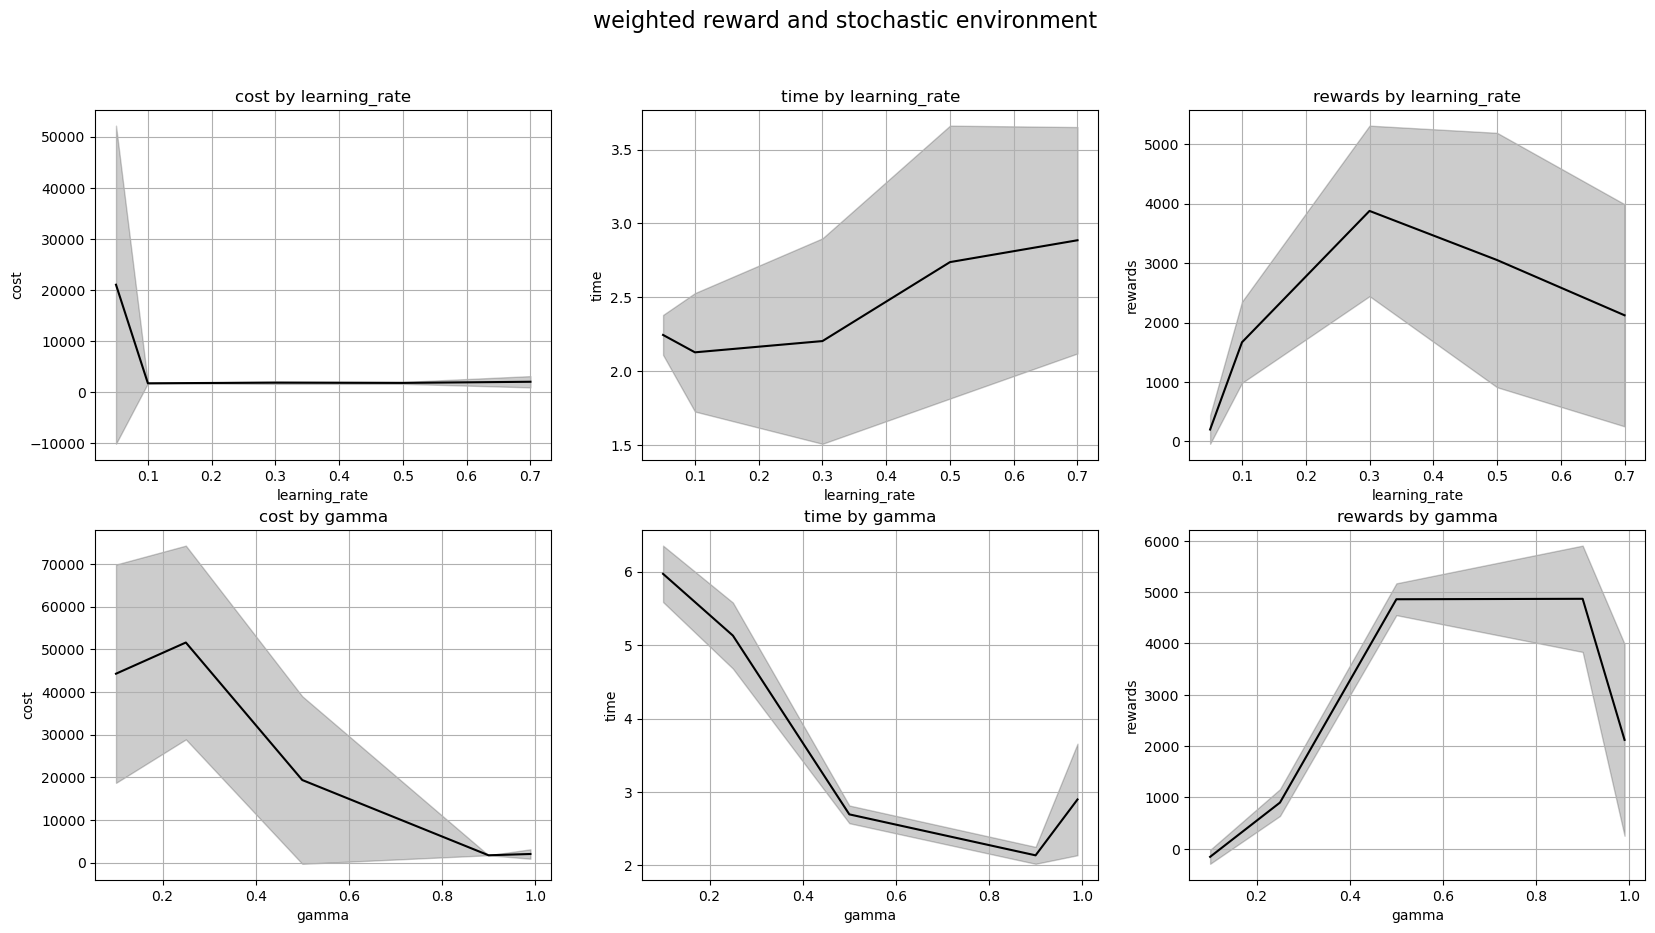

In [30]:
analysis_results("weighted", "stochastic")

## Model generalization

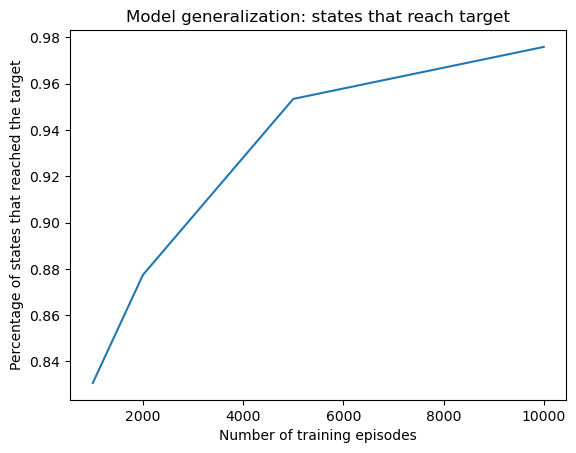

In [61]:
env = Environment(G, source, target, reward = "weighted", mode = "deterministic")
n_episodes_list = [1000, 2000, 5000, 10000]
reach_list = []
for n_episodes in n_episodes_list:
    env.reset()
    agent = QLAgent(env, learning_rate=0.3, gamma = 0.9, n_episodes=n_episodes)
    agent.train()


    n_reached = 0
    n_possible = len(G.nodes)
    for i in range(len(G.nodes)):
        _, cost = agent.route_to_target(G, i, target)
        try:
            opt_cost = nx.shortest_path_length(G, i, target, weight="length")
            if cost < np.inf:
                n_reached += 1
        except:
            n_possible -= 1
    
    reach_list.append(n_reached / n_possible)

plt.plot(n_episodes_list, reach_list)
plt.xlabel("Number of training episodes")
plt.ylabel("Percentage of states that reached the target")
plt.title("Model generalization: states that reach target")
plt.show()


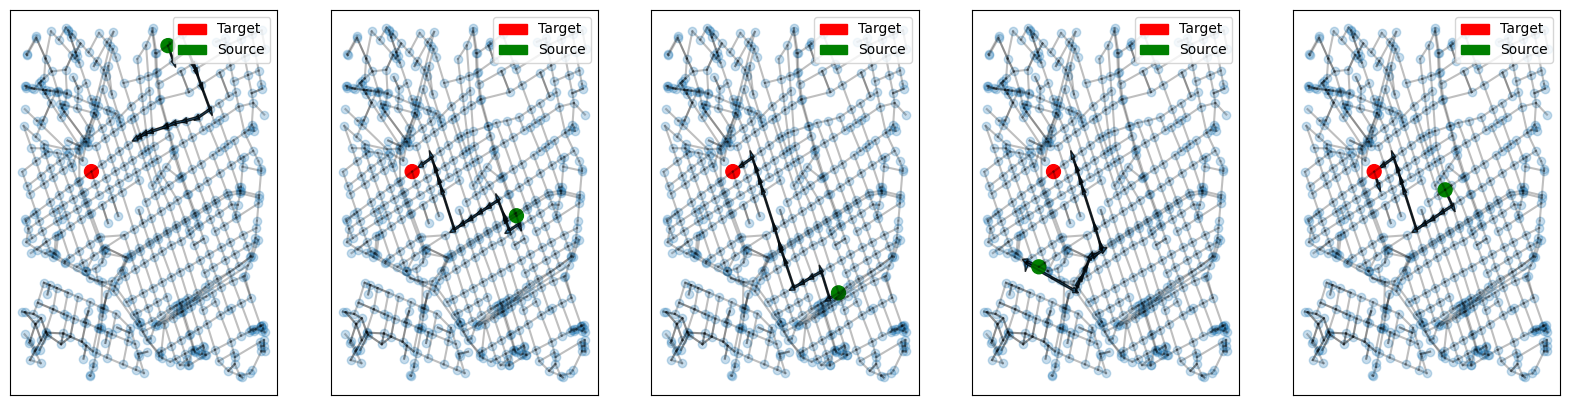

In [31]:
random_states = []

while len(random_states) < 5:
    state = np.random.choice(list(G.nodes))
    if state not in random_states and nx.has_path(G, state, target):
        random_states.append(state)

#fig, axs = plt.subplots(nrows = 1, ncols = 5)

fig = plt.figure(figsize=(20, 5))

for i, state in enumerate(random_states):
    route, cost = agent.route_to_target(G, state, target)

    steps = min(15, len(route))
    plt.subplot(1, 5, i + 1)
    plot_few_steps_policy(G, agent.policy, state, target, steps=steps)

In [50]:
def experiment_handler2(seeds, env, agent_params = {}):
    results = []
    env.reset()
    for i, seed in tqdm(enumerate(seeds)):
        np.random.seed(seed)
        source, target = np.random.choice(env.get_n_states(), size = 2)
        while not nx.has_path(G, source, target):
            source, target = np.random.choice(env.get_n_states(), size = 2)
        
        env.source = source
        env.target = target
        env.reset()

        start = time()
        agent = QLAgent(env = env, seed = seed, **agent_params)  
        agent.train()
        end = time()
        route, cost = agent.route_to_target(G, env.source, env.target)
        optim_cost = nx.shortest_path_length(G, source, target, weight="length")
        
        results.append({
            "seed" : seed,
            "source" : source,
            "target" : target,
            "cost" : cost / optim_cost,    
            "time" : end - start,
            "rewards" : agent.episode_rewards,
        })
    return results

In [51]:
agent_params = {
    "n_episodes" : 1000,
    "max_steps" : 1000,
    "learning_rate" : 0.6,
    "gamma" : 0.7,
}
for scheme in ["unit", "weighted"]:
    for simul in ["deterministic", "stochastic"]:
        env = Environment(G, 0, 1, scheme, simul)
        results_general = experiment_handler2(
            seeds,
            env,
            agent_params,
        )
        pd.DataFrame(results_general).to_json(f"results/{scheme}_{simul}_general.json")

20it [00:34,  1.74s/it]
20it [00:38,  1.94s/it]
20it [00:39,  1.99s/it]
20it [00:40,  2.00s/it]


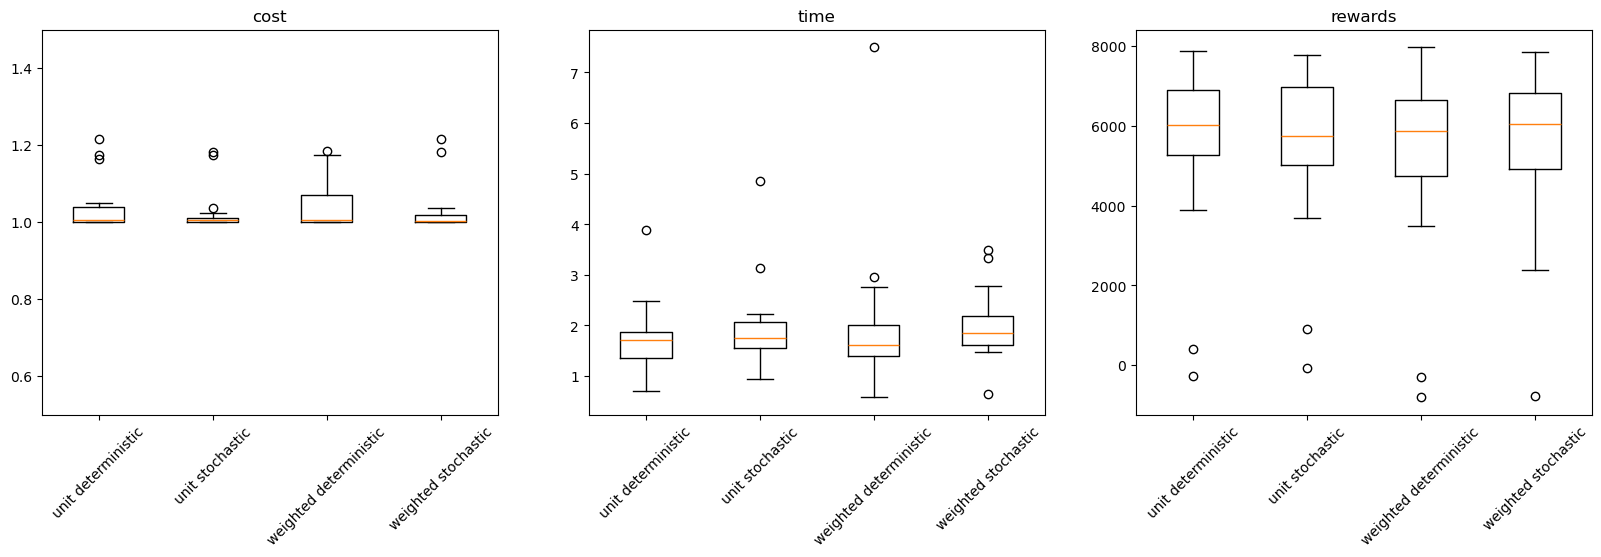

In [60]:

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 5))
for i, metric in enumerate(["cost", "time", "rewards"]):
    results_to_plot = []
    for scheme in ["unit", "weighted"]:
        for simul in ["deterministic", "stochastic"]:
            result = pd.read_json(f"results/{scheme}_{simul}_general.json")
            result["rewards"] = result["rewards"].apply(np.mean)
            results_to_plot.append(result[metric])
    axs[i].boxplot(results_to_plot)
    if i == 0:
        axs[i].set_ylim(0.5, 1.5)

    axs[i].set_xticklabels(["unit deterministic", "unit stochastic", "weighted deterministic", "weighted stochastic"], rotation = 45)
    axs[i].set_title(metric)